In [218]:
from HeaderP import *

In [219]:
import Astraea

In [220]:
def readsimdata(simNo,z,Rcut,select,Rcut_thread,zcut_thread):
    if simNo=='data':
        data=pd.read_pickle('../SecondYear/CannonDR16_cut.pkl')
        data['z_today']=data['z']
        data['x_today']=data['X']
        data['y_today']=data['Y']
        data['feh_scale']=data['M_H']
        data['ofe_scale']=data['O_FE']
        data['age']=data['Age']
    elif select:
        data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'_apogee_selec.pkl')
        data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
        data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
        scale_fe=0.250019907951355/0.35828184923028494
        scale_o=0.10861970484256744/0.09543676896214373
        data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
        data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
        data['dR']=data['R']-data['R_bir']
        data['dz']=abs(data['z_today'])-abs(data['z_birth'])
    
    elif not select:
        if z=='0':
            data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'.pkl')
        else:
            data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'_z'+z+'.pkl')
            try:
                data['x_today']=data['x']
                data['y_today']=data['y']
                data['z_today']=data['z']
            except:
                print(np.shape(data['x_today']))

        data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
        data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
        scale_fe=0.250019907951355/0.35828184923028494
        scale_o=0.10861970484256744/0.09543676896214373
        data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
        data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
        
        if Rcut:
            data=data.loc[data['R_bir']<Rcut_thread].reset_index(drop=True)
            data=data.loc[abs(data['z_birth'])<zcut_thread].reset_index(drop=True)
        data['dR']=data['R']-data['R_bir']
        data['dz']=abs(data['z_today'])-abs(data['z_birth'])
    return data
        

# load simulation

In [240]:
simNo='2_79e12'
z='0'
Rcut=True
select=False
Rcut_thread=30
zcut_thread=5


data=readsimdata(simNo,z,Rcut,select,Rcut_thread,zcut_thread)
#data=data.loc[data['age']<3]

# use only [Fe/H] and Age

In [241]:
def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

In [242]:
from itertools import combinations_with_replacement

args = data['feh_scale'], data['age']
args_name = '[Fe/H]', 'Age'
X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    X_names.append(str(a + '*' + b))
    
    
X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))

(7528957, 5) (5,) 2


In [243]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = data['R_bir'].values

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

In [244]:
weights = train(y_train, X_train)

(-50.0, 20.0)

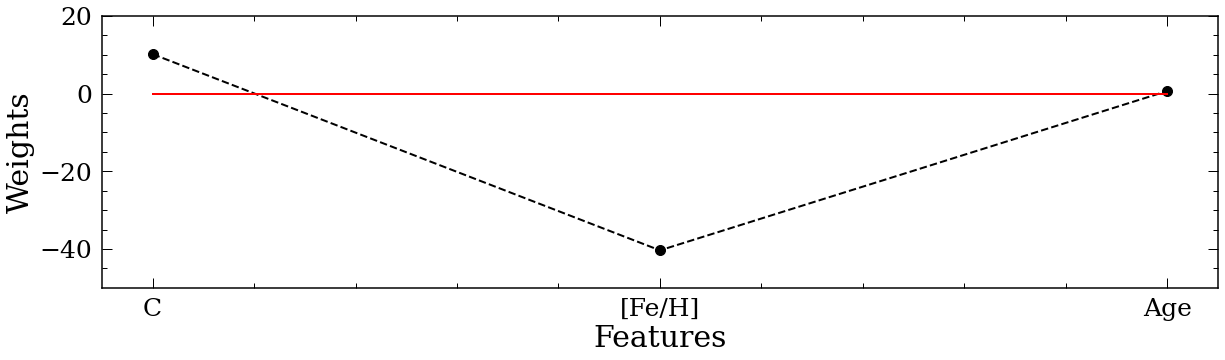

In [245]:
plt.figure(figsize=(20,5))
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)], weights[:(len(args_name)+1)], 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)],np.zeros(len(np.append(['C'],X_names)))[:(len(args_name)+1)],'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-50,20])

(-50.0, 20.0)

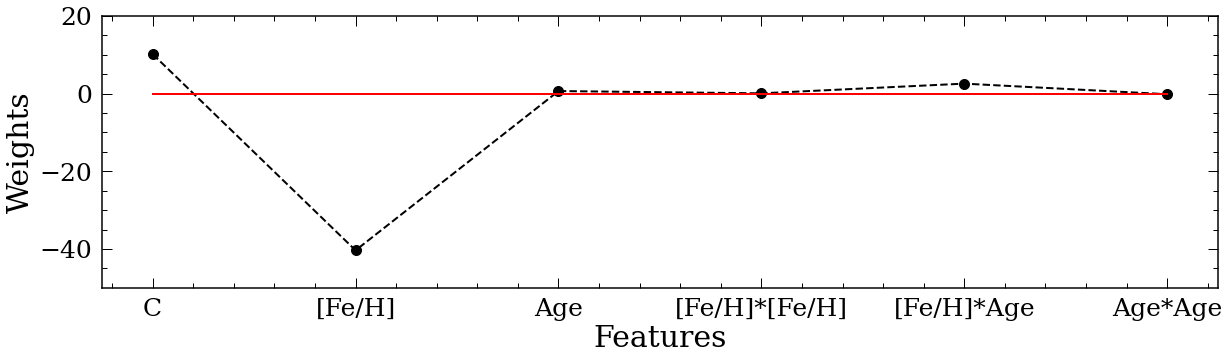

In [246]:
plt.figure(figsize=(20,5))
plt.plot(np.append(['C'],X_names), weights, 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names),np.zeros(len(np.append(['C'],X_names))),'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-50,20])

In [247]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

In [248]:
"""
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing
from mlxtend.evaluate import bias_variance_decomp
model = LinearRegression()
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model, X_train,
                                                            y_train, X_test,
                                                            y_test,
                                                            loss='mse',
                                                            num_rounds=50,
                                                            random_seed=20)
"""

"\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.datasets import fetch_california_housing\nfrom mlxtend.evaluate import bias_variance_decomp\nmodel = LinearRegression()\navg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model, X_train,\n                                                            y_train, X_test,\n                                                            y_test,\n                                                            loss='mse',\n                                                            num_rounds=50,\n                                                            random_seed=20)\n"

Text(0.5, 1.0, 'scatter = 1.85601; bias = -0.00269')

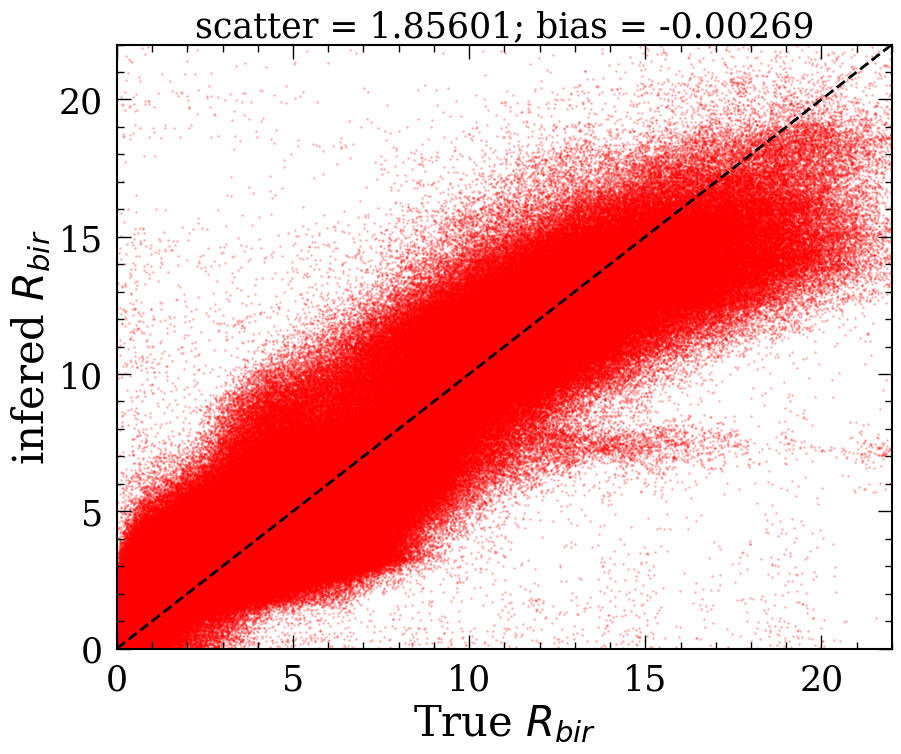

In [249]:
xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_test, y_predict.T, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)

# use [Fe/H], R, and Age

In [250]:
args = data['feh_scale'], data['R'], data['age']
args_name = '$θ_{[Fe/H]}$', '$θ_R$', '$θ_τ$'
X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    if a==b=='$θ_{[Fe/H]}$':
        X_names.append('$θ_{[Fe/H]^2}$')
    elif a==b=='$θ_R$':
        X_names.append('$θ_{R^2}$')
    elif a==b=='$θ_τ$':
        X_names.append('$θ_{τ^2}$')
    else:
        X_names.append(str(a + '*' + b))
    
    
X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))

(7528957, 9) (9,) 3


In [251]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = data['R_bir'].values

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

In [252]:
weights = train(y_train, X_train)

(-50.0, 50.0)

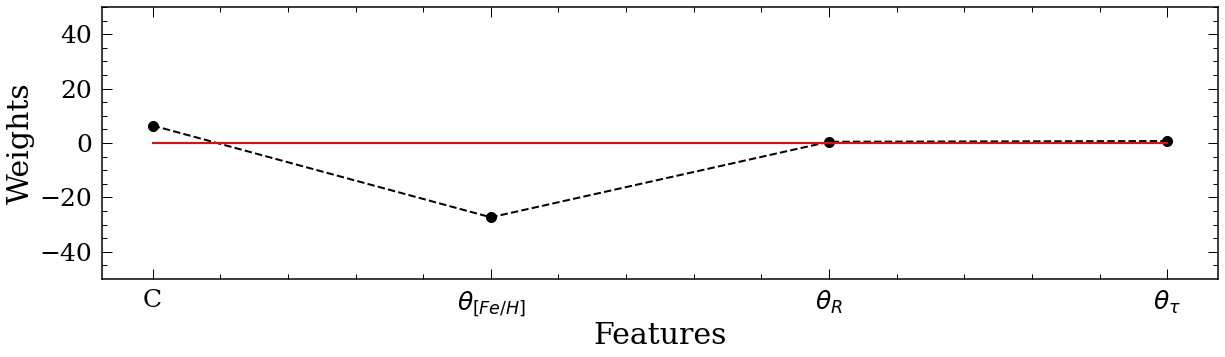

In [253]:
plt.figure(figsize=(20,5))
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)], weights[:(len(args_name)+1)], 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)],np.zeros(len(np.append(['C'],X_names)))[:(len(args_name)+1)],'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-50,50])

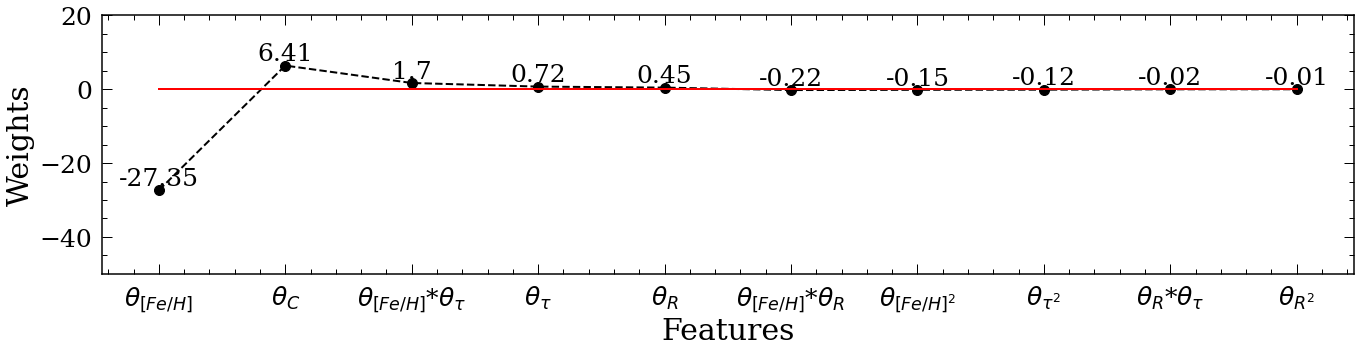

In [254]:
plt.figure(figsize=(19,5))
allnames = np.append(['$θ_C$'],X_names)
absweights, weights_imp, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.plot(allnames, weights_imp, 'k--o', markersize=10)
plt.plot(allnames,np.zeros(len(np.append(['C'],X_names))),'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-50,20])

for i, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (allnames[i], weights_imp[i]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig('importance.png')


In [255]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

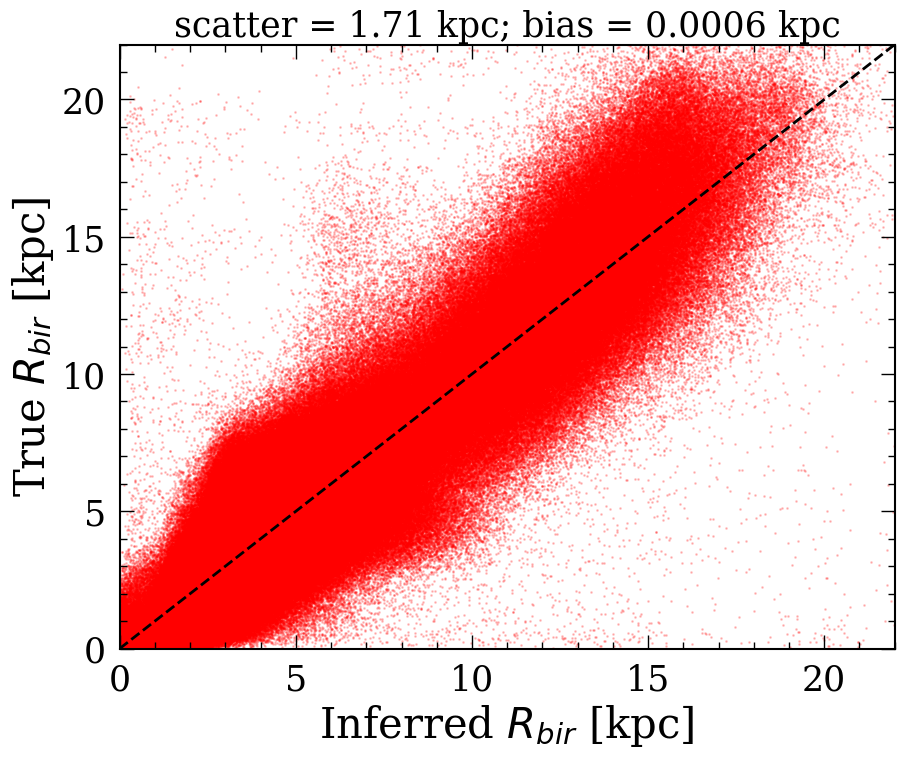

In [256]:
xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_predict.T, y_test, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("Inferred $R_{bir}$ [kpc]")
plt.ylabel("True $R_{bir}$ [kpc]")
plt.title('scatter = %.2f kpc; bias = %.4f kpc'%(scatter, bias),fontsize=25)
plt.savefig('Rbirth.png')

# use [Fe/H], [O/Fe], and Age

In [127]:
args = data['feh_scale'], data['ofe_scale'], data['age']
args_name = '[Fe/H]', '[O/Fe]', 'Age'
X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    X_names.append(str(a + '*' + b))
    
    
X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))

(7528957, 9) (9,) 3


In [128]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = data['R_bir'].values

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

In [129]:
weights = train(y_train, X_train)

(-150.0, 150.0)

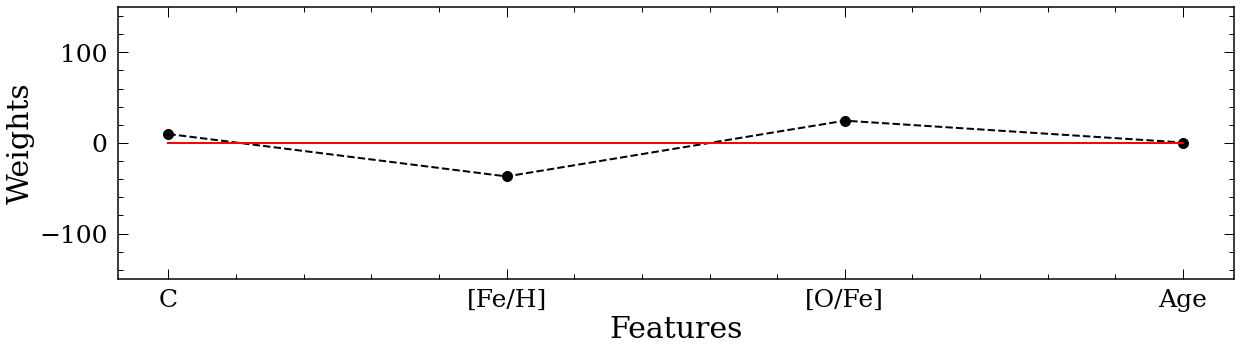

In [130]:
plt.figure(figsize=(20,5))
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)], weights[:(len(args_name)+1)], 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)],np.zeros(len(np.append(['C'],X_names)))[:(len(args_name)+1)],'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-150,150])

In [131]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

Text(0.5, 1.0, 'scatter = 1.81676; bias = -0.00068')

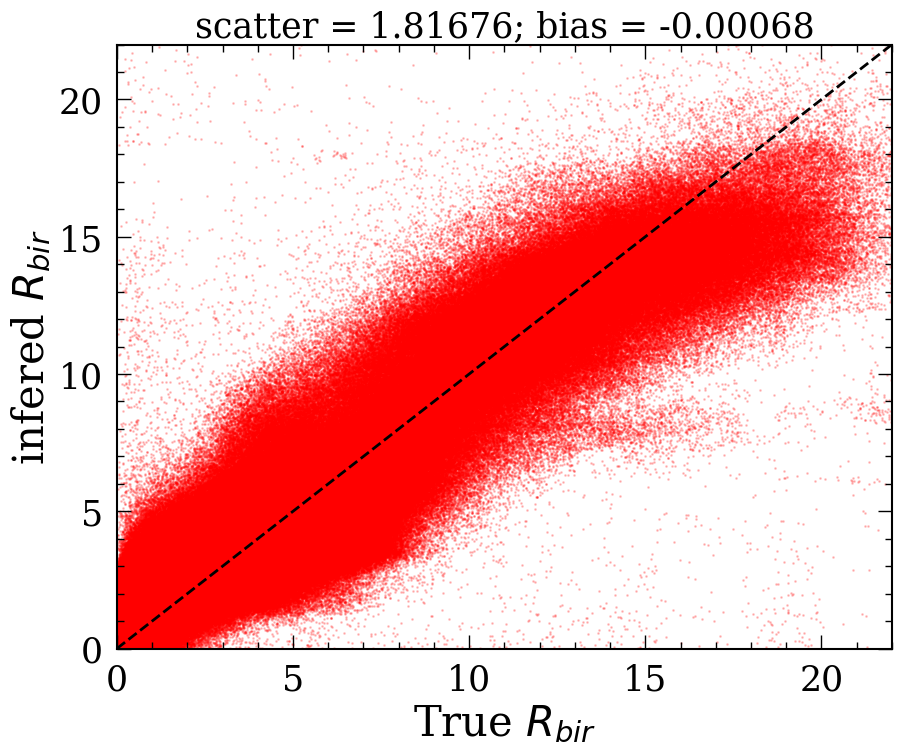

In [132]:
xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_test, y_predict.T, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)

# All features

In [133]:
args = data['feh_scale'], data['ofe_scale'], data['age'], data['vx'], data['vy'], data['vz'], data['x'], data['y'], data['z'], data['mass'], data['Jr'], data['Jphi'], data['Jz'], data['R'] 
args_name = '[Fe/H]', '[O/Fe]', 'Age', 'vx', 'vy', 'vz', 'x', 'y', 'z', 'mass', 'Jr', 'Jphi', 'Jz', 'R'

X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    X_names.append(str(a + '*' + b))
    
    
X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))


(7528957, 119) (119,) 14


In [134]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = data['R_bir'].values

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

In [135]:
weights = train(y_train, X_train)

(-500.0, 500.0)

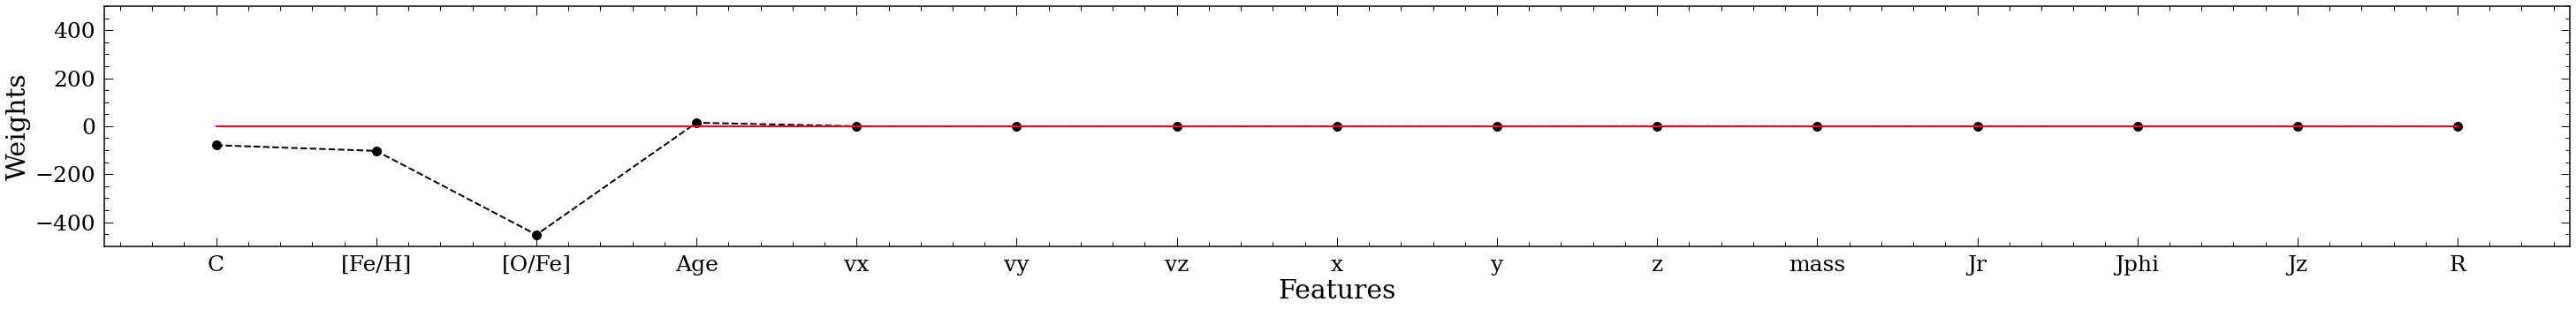

In [136]:
plt.figure(figsize=(50,5))
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)], weights[:(len(args_name)+1)], 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)],np.zeros(len(np.append(['C'],X_names)))[:(len(args_name)+1)],'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-500,500])

In [137]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

Text(0.5, 1.0, 'scatter = 1.52306; bias = 0.00010')

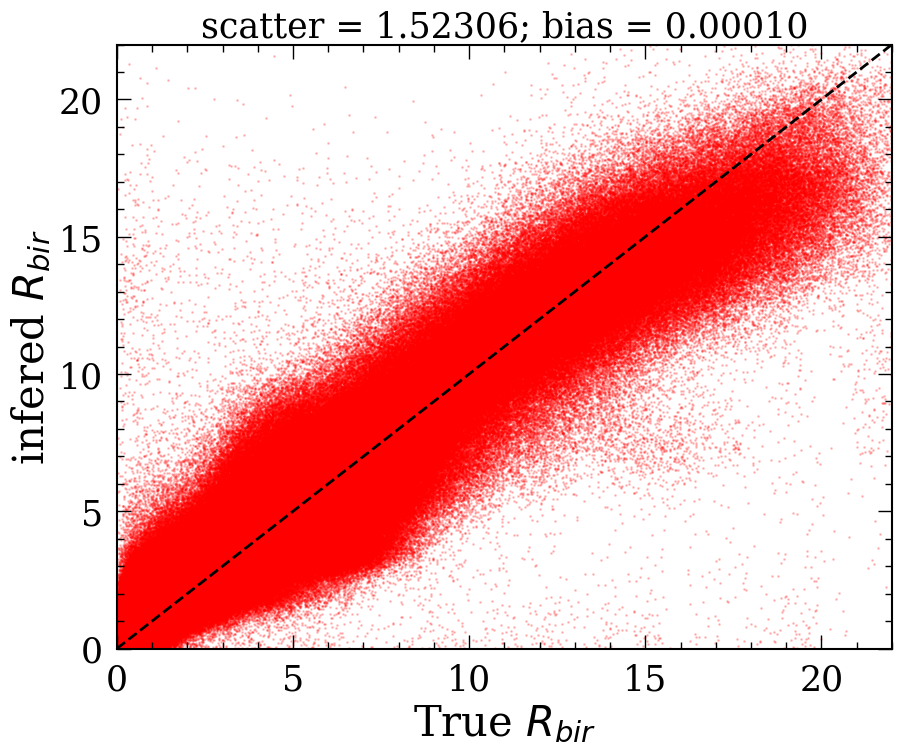

In [138]:
xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_test, y_predict.T, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)

# Try the one with 15 abundances

In [314]:
Rcut_thread=30
data=pd.read_pickle('./Tobias/g8.26e11.pkl')
data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
data['R']=np.sqrt(data['x']**2+data['y']**2)
#data['dR']=data['R']-data['R_bir']

        

In [315]:
args = data['feh'], data['R'], data['age']
args_name = '$θ_{[Fe/H]}$', '$θ_R$', '$θ_τ$'
X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    if a==b=='$θ_{[Fe/H]}$':
        X_names.append('$θ_{[Fe/H]^2}$')
    elif a==b=='$θ_R$':
        X_names.append('$θ_{R^2}$')
    elif a==b=='$θ_τ$':
        X_names.append('$θ_{τ^2}$')
    else:
        X_names.append(str(a + '*' + b))
    
    
X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))

(622283, 9) (9,) 3


(-50.0, 50.0)

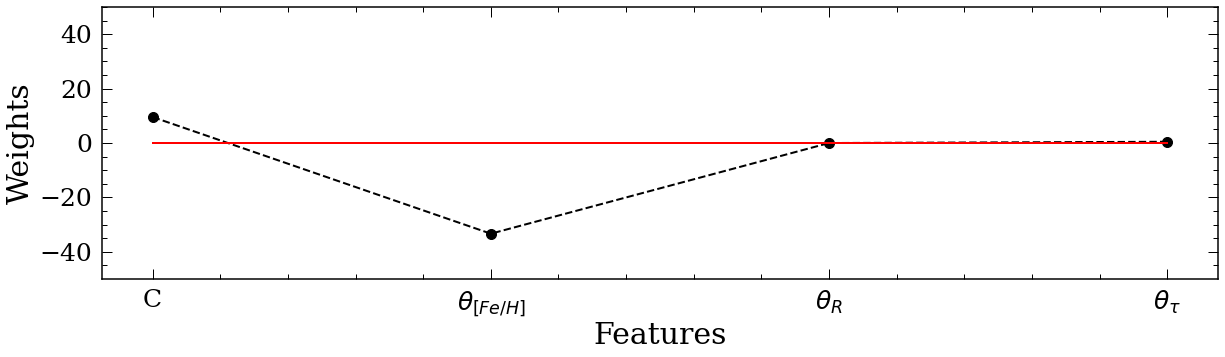

In [316]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = data['Rbir'].values

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

weights = train(y_train, X_train)

plt.figure(figsize=(20,5))
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)], weights[:(len(args_name)+1)], 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)],np.zeros(len(np.append(['C'],X_names)))[:(len(args_name)+1)],'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-50,50])

(-50.0, 20.0)

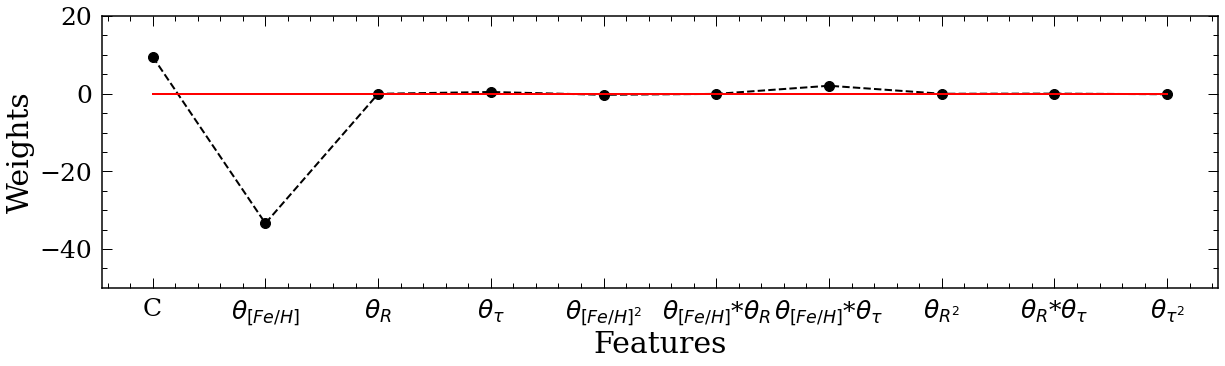

In [317]:
plt.figure(figsize=(20,5))
plt.plot(np.append(['C'],X_names), weights, 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names),np.zeros(len(np.append(['C'],X_names))),'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-50,20])

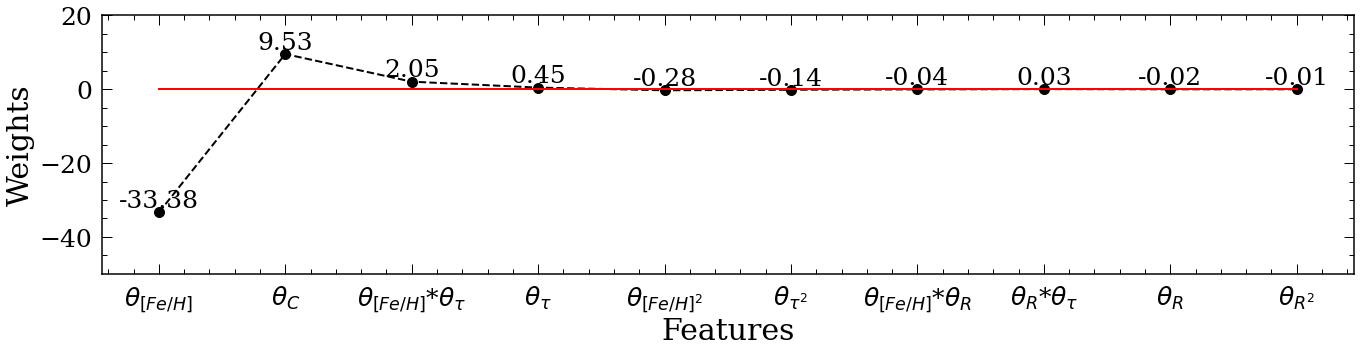

In [318]:
plt.figure(figsize=(19,5))
allnames = np.append(['$θ_C$'],X_names)
absweights, weights_imp, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.plot(allnames, weights_imp, 'k--o', markersize=10)
plt.plot(allnames,np.zeros(len(np.append(['C'],X_names))),'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-50,20])

for i, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (allnames[i], weights_imp[i]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig('importance.png')



In [319]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

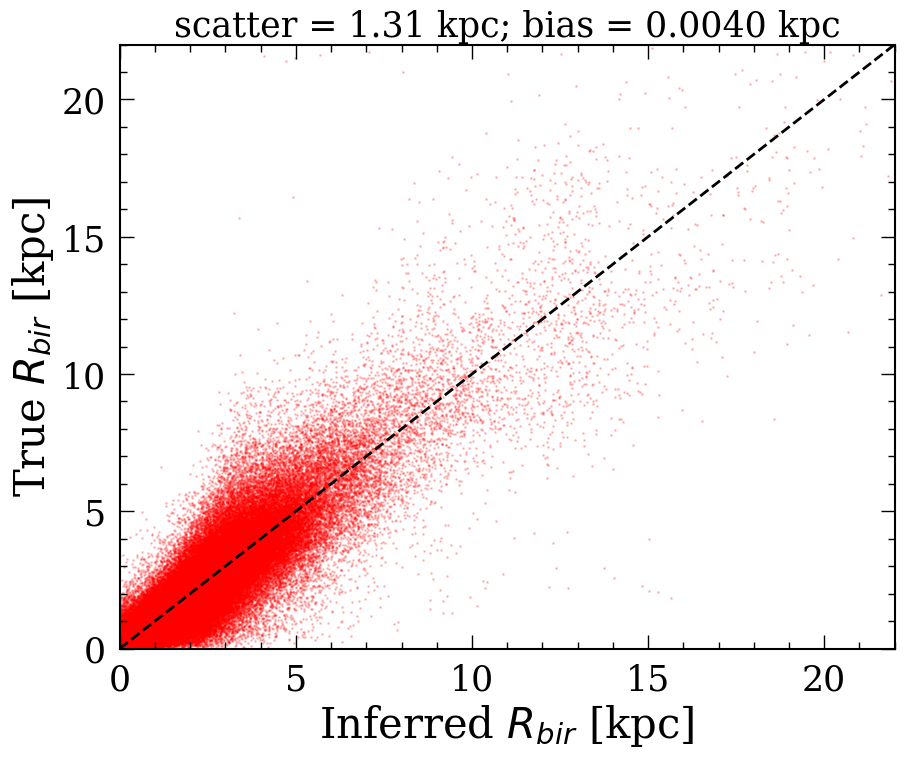

In [320]:
xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_predict.T, y_test, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("Inferred $R_{bir}$ [kpc]")
plt.ylabel("True $R_{bir}$ [kpc]")
plt.title('scatter = %.2f kpc; bias = %.4f kpc'%(scatter, bias),fontsize=25)
plt.savefig('Rbirth.png')

# Try the one with 15 abundances at an earlier snapshot

In [321]:
Stimes = np.load('./Tobias/snapshots.npy')
Ctimes = np.load('./Tobias/cosmictime.npy')

In [322]:
timelookup = {np.round(Ctimes[i],8):Stimes[i] for i in range(len(Ctimes))}
print(Ctimes)

[ 0.23829648  0.45896157  0.67962667  0.90029177  1.12095687  1.34162197
  1.56228707  1.78295216  2.00361726  2.22428236  2.66561256  2.88627766
  3.10694276  3.32760785  3.54827295  3.76893805  3.98960315  4.21026825
  4.43093335  4.65159844  4.87226354  5.09292864  5.31359374  5.53425884
  5.75492394  5.97558903  6.19625413  6.41691923  6.63758433  6.85824943
  7.07891453  7.29957962  7.52024472  7.74090982  7.96157492  8.18224002
  8.40290512  8.62357021  8.84423531  9.06490041  9.28556551  9.50623061
  9.72689571  9.9475608  10.1682259  10.388891   10.6095561  10.8302212
 11.0508863  11.27155139 11.49221649 11.71288159 11.93354669 12.15421179
 12.37487689 12.59554198 12.81620708 13.03687218 13.25753728 13.47820238
 13.69886748 14.14019767]


In [323]:
testtime = 10.1682259

data['R_'+timelookup[testtime]] = np.sqrt(data['x_'+timelookup[testtime]]**2+data['y_'+timelookup[testtime]]**2)
data_ct = data.dropna(subset=['feh','R_'+ timelookup[testtime], 'age', 'Rbir'])
args = data_ct['feh'], data_ct['R_'+timelookup[testtime]], data_ct['age']
args_name = '$θ_{[Fe/H]}$', '$θ_R$', '$θ_τ$'
X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    if a==b=='$θ_{[Fe/H]}$':
        X_names.append('$θ_{[Fe/H]^2}$')
    elif a==b=='$θ_R$':
        X_names.append('$θ_{R^2}$')
    elif a==b=='$θ_τ$':
        X_names.append('$θ_{τ^2}$')
    else:
        X_names.append(str(a + '*' + b))
    
    
X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))

(530063, 9) (9,) 3


In [324]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = data_ct['Rbir'].values

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

In [325]:
weights = train(y_train, X_train)

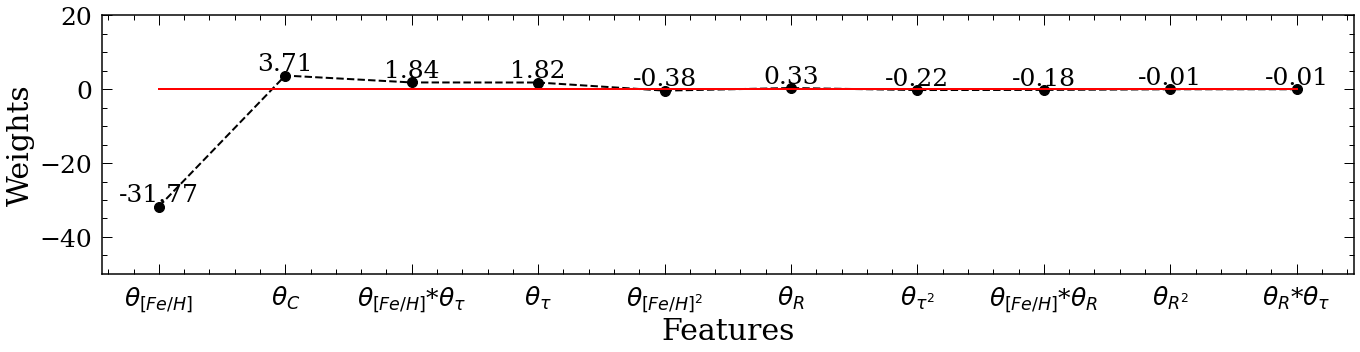

In [326]:
plt.figure(figsize=(19,5))
allnames = np.append(['$θ_C$'],X_names)
absweights, weights_imp, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.plot(allnames, weights_imp, 'k--o', markersize=10)
plt.plot(allnames,np.zeros(len(np.append(['C'],X_names))),'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-50,20])

for i, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (allnames[i], weights_imp[i]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()




In [327]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

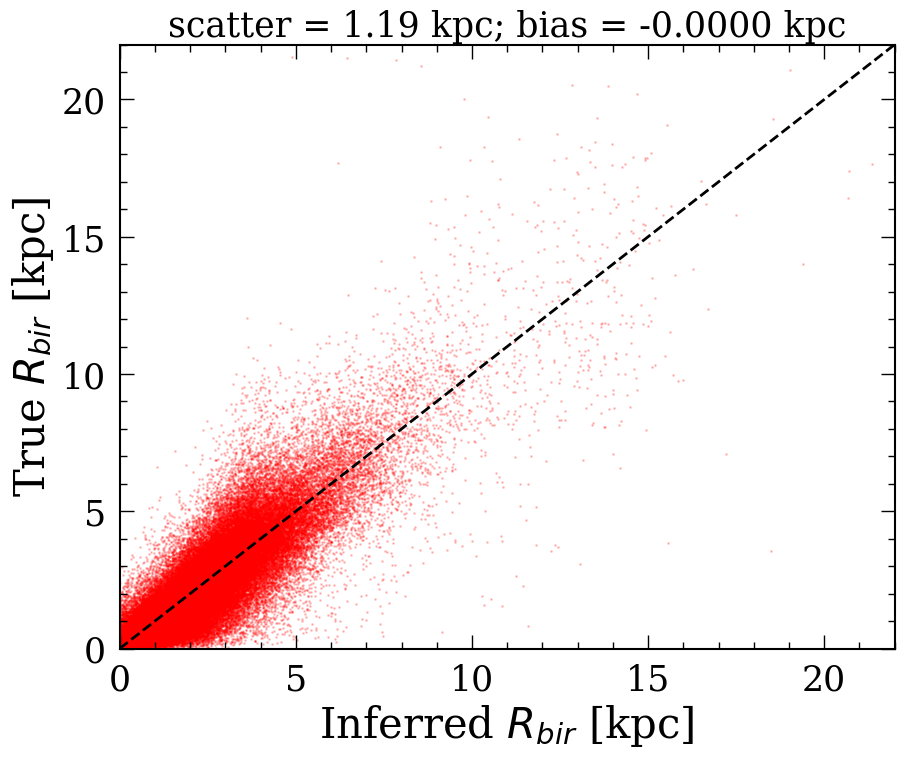

In [328]:
xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_predict.T, y_test, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("Inferred $R_{bir}$ [kpc]")
plt.ylabel("True $R_{bir}$ [kpc]")
plt.title('scatter = %.2f kpc; bias = %.4f kpc'%(scatter, bias),fontsize=25)
plt.savefig('Rbirth.png')

## test all times

In [334]:
"""
weights = np.zeros((len(Ctimes), 10))
scatterings = np.zeros(len(Ctimes))
biases = np.zeros(len(Ctimes))
numbstars = np.zeros(len(Ctimes))

for i, testtime in enumerate(Ctimes):
    testtime = np.round(testtime, 8)
    try: 
        print(len(data['x_'+timelookup[testtime]]))
    except:
        continue
    data['R_'+timelookup[testtime]] = np.sqrt(data['x_'+timelookup[testtime]]**2+data['y_'+timelookup[testtime]]**2)
    data_ct = data.dropna(subset=['feh','R_'+ timelookup[testtime], 'age', 'Rbir'])
    args = data_ct['feh'], data_ct['R_'+timelookup[testtime]], data_ct['age']
    X = list(args)
    for a, b in combinations_with_replacement(args, 2):
        X.append(a * b)

    X = np.array(X).T
    
    
    # Define the number of training and validating stars.
    Ntrain = int(0.8*np.shape(X)[0])
    y = data_ct['Rbir'].values

    # Choose stars at random and split.
    shuffle_inds = np.arange(len(y))
    np.random.shuffle(shuffle_inds)
    train_inds = shuffle_inds[:Ntrain]
    test_inds = shuffle_inds[Ntrain:]
    y_train, X_train = y[train_inds], X[train_inds, :]
    y_test, X_test = y[test_inds], X[test_inds, :]
    
    weights[i, :] = train(y_train, X_train)
    
    A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
    y_predict = np.dot(weights[i, :].T, A.T)
    
    scatterings[i] = np.std(y_test-y_predict)
    biases[i]  = np.mean(y_test-y_predict)
    
    numbstars[i] = len(data_ct)
""" 

"\nweights = np.zeros((len(Ctimes), 10))\nscatterings = np.zeros(len(Ctimes))\nbiases = np.zeros(len(Ctimes))\nnumbstars = np.zeros(len(Ctimes))\n\nfor i, testtime in enumerate(Ctimes):\n    testtime = np.round(testtime, 8)\n    try: \n        print(len(data['x_'+timelookup[testtime]]))\n    except:\n        continue\n    data['R_'+timelookup[testtime]] = np.sqrt(data['x_'+timelookup[testtime]]**2+data['y_'+timelookup[testtime]]**2)\n    data_ct = data.dropna(subset=['feh','R_'+ timelookup[testtime], 'age', 'Rbir'])\n    args = data_ct['feh'], data_ct['R_'+timelookup[testtime]], data_ct['age']\n    X = list(args)\n    for a, b in combinations_with_replacement(args, 2):\n        X.append(a * b)\n\n    X = np.array(X).T\n    \n    \n    # Define the number of training and validating stars.\n    Ntrain = int(0.8*np.shape(X)[0])\n    y = data_ct['Rbir'].values\n\n    # Choose stars at random and split.\n    shuffle_inds = np.arange(len(y))\n    np.random.shuffle(shuffle_inds)\n    train_in

In [335]:
#weights, scatterings, biases, numbstars = np.save('weights',weights), np.save('scatterings',scatterings), np.save('biases',biases), np.save('numbstars',numbstars)

weights, scatterings, biases, numbstars = np.load('weights.npy'), np.load('scatterings.npy'), np.load('biases.npy'), np.load('numbstars.npy')

m_filt = (scatterings!=0)
weights, scatterings, biases, numbstars = np.array(weights[m_filt,:]), np.array(scatterings[m_filt]), np.array(biases[m_filt]), np.array(numbstars[m_filt])
lookbacktime = Ctimes[m_filt]


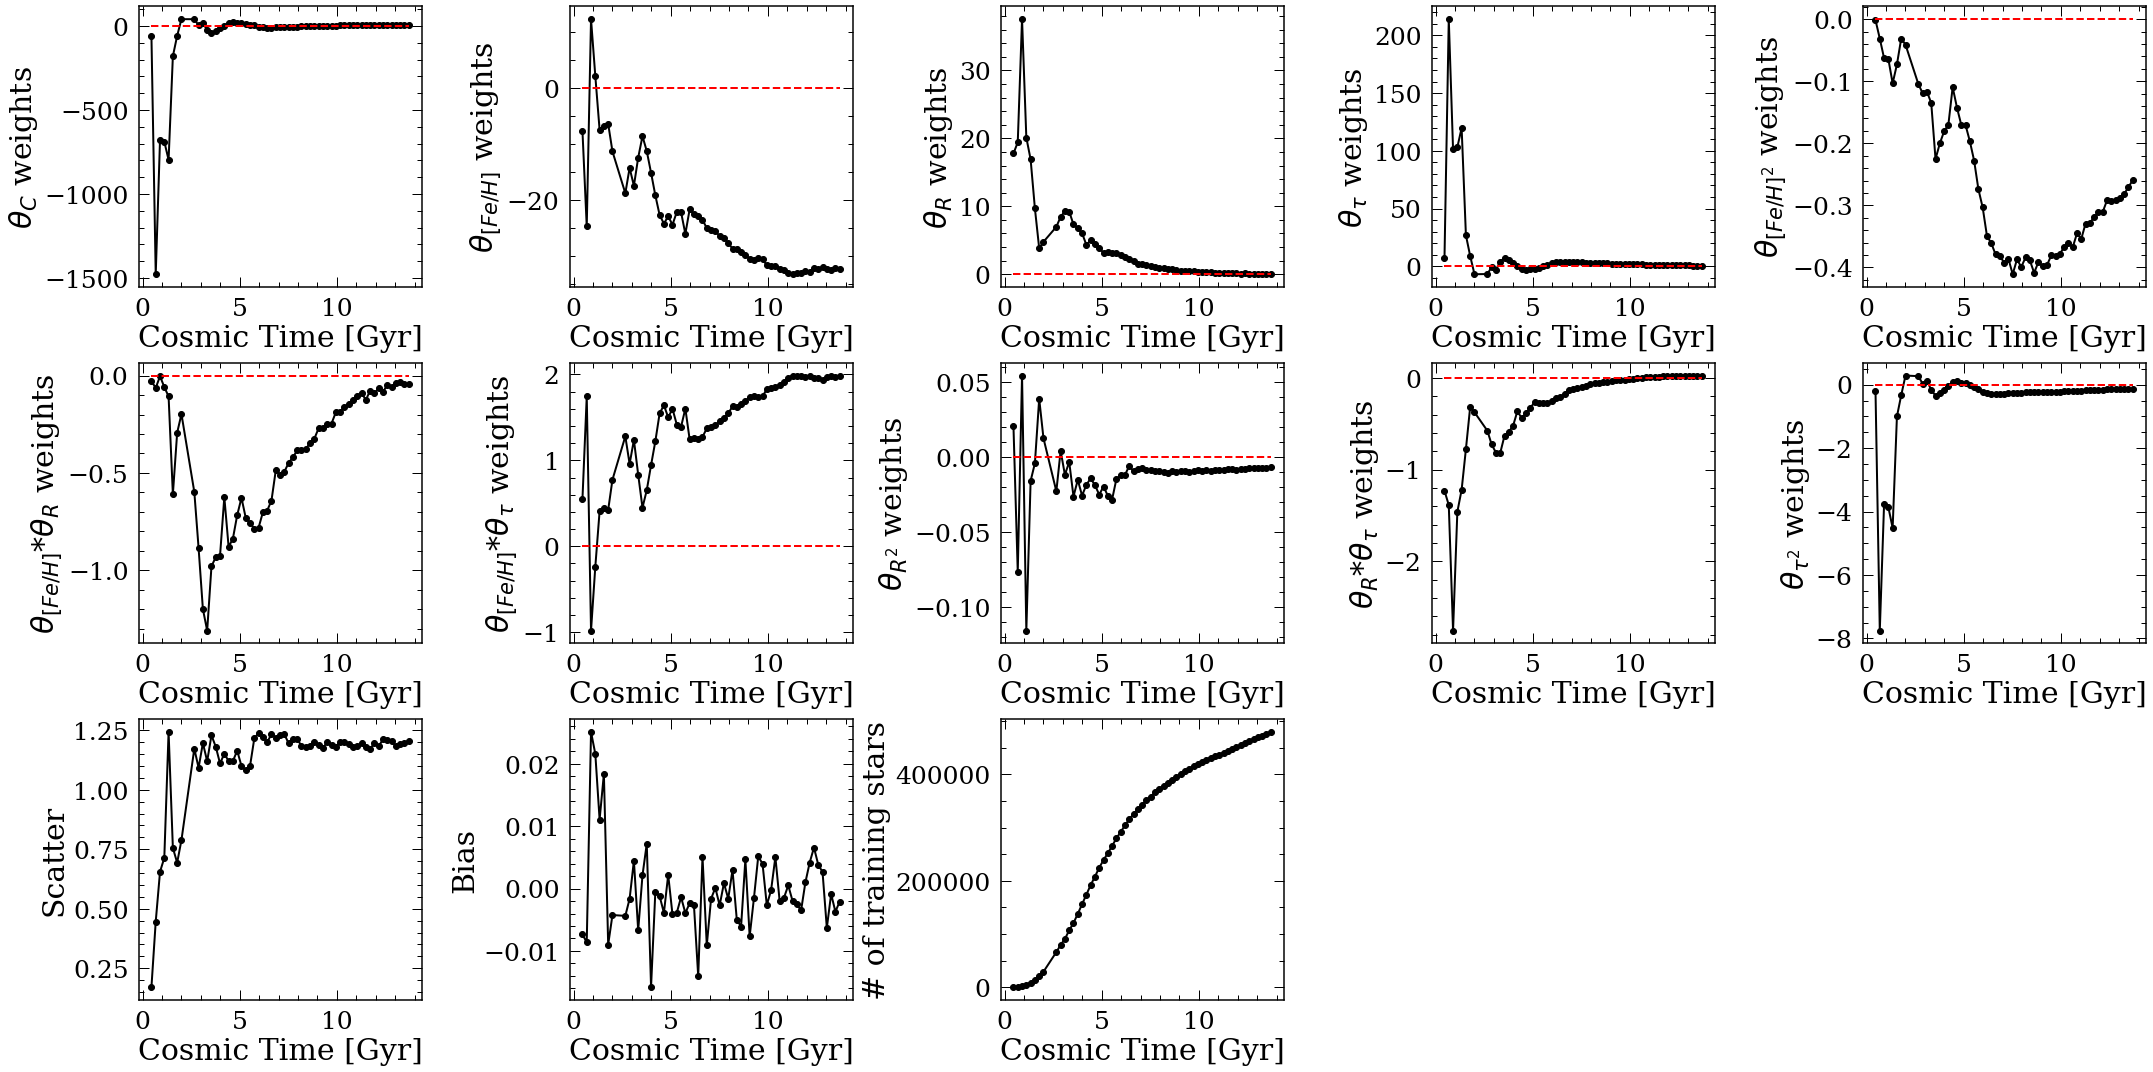

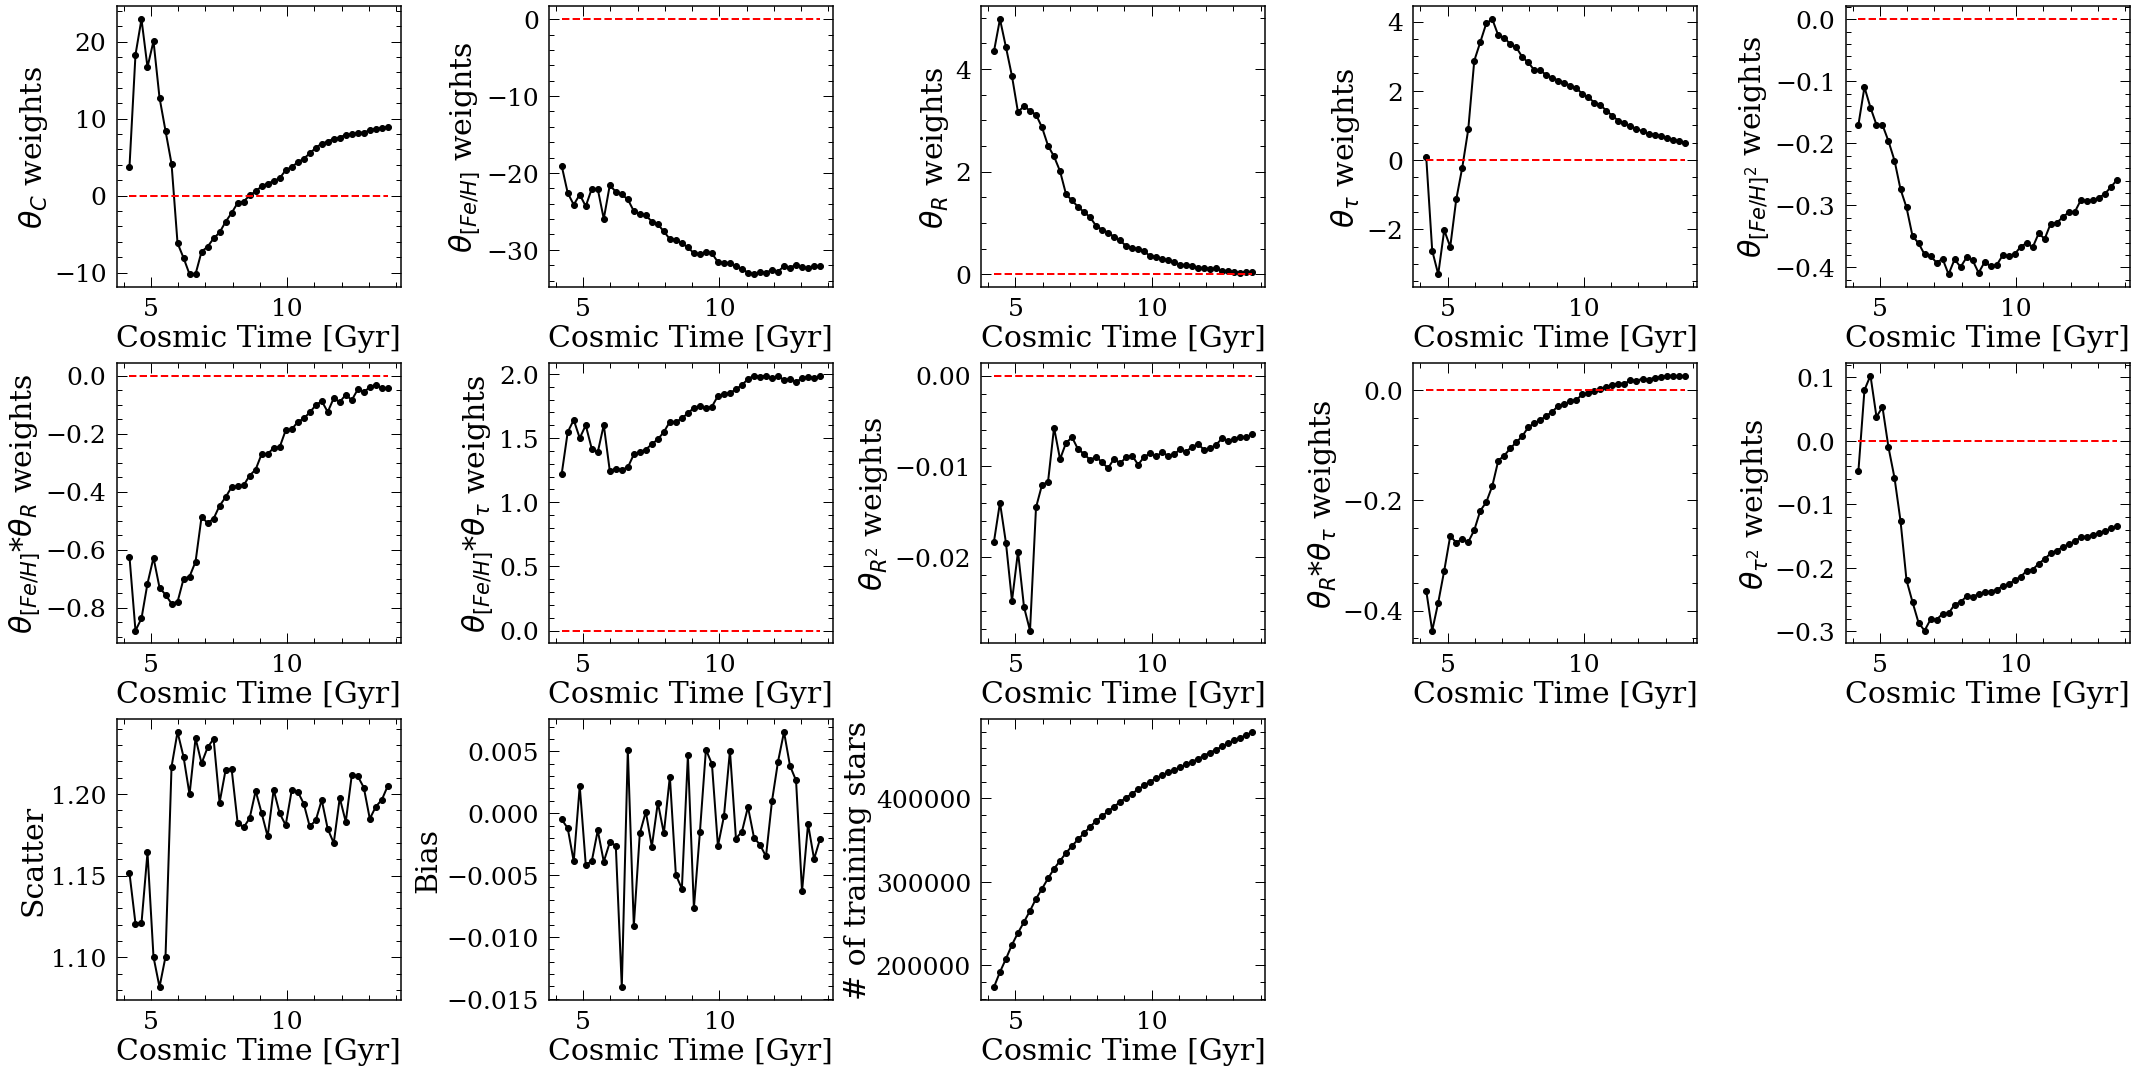

In [336]:
plt.figure(figsize=(30,15))
allnames = np.append(['$θ_C$'],X_names)
for i in range(len(allnames)):
    plt.subplot(3,5,i+1)
    plt.plot(lookbacktime, weights[:,i],'ko-')
    plt.plot(lookbacktime, np.zeros(len(lookbacktime)), 'r--')
    plt.xlabel('Cosmic Time [Gyr]')
    plt.ylabel(allnames[i]+' weights')

plt.subplot(3,5,11)
plt.plot(lookbacktime, scatterings,'ko-')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('Scatter')

plt.subplot(3,5,12)
plt.plot(lookbacktime, biases,'ko-')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('Bias')

plt.subplot(3,5,13)
plt.plot(lookbacktime, numbstars*0.8,'ko-')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('# of training stars')

plt.tight_layout()
plt.savefig('time_evolution.png')




### only with > 1000000 stars
m_ns = (numbstars>200000)
plt.figure(figsize=(30,15))
allnames = np.append(['$θ_C$'],X_names)
for i in range(len(allnames)):
    plt.subplot(3,5,i+1)
    plt.plot(lookbacktime[m_ns], weights[:,i][m_ns],'ko-')
    plt.plot(lookbacktime[m_ns], np.zeros(len(lookbacktime[m_ns])), 'r--')
    plt.xlabel('Cosmic Time [Gyr]')
    plt.ylabel(allnames[i]+' weights')

plt.subplot(3,5,11)
plt.plot(lookbacktime[m_ns], scatterings[m_ns],'ko-')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('Scatter')

plt.subplot(3,5,12)
plt.plot(lookbacktime[m_ns], biases[m_ns],'ko-')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('Bias')

plt.subplot(3,5,13)
plt.plot(lookbacktime[m_ns], numbstars[m_ns]*0.8,'ko-')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('# of training stars')

plt.tight_layout()

# Use only R

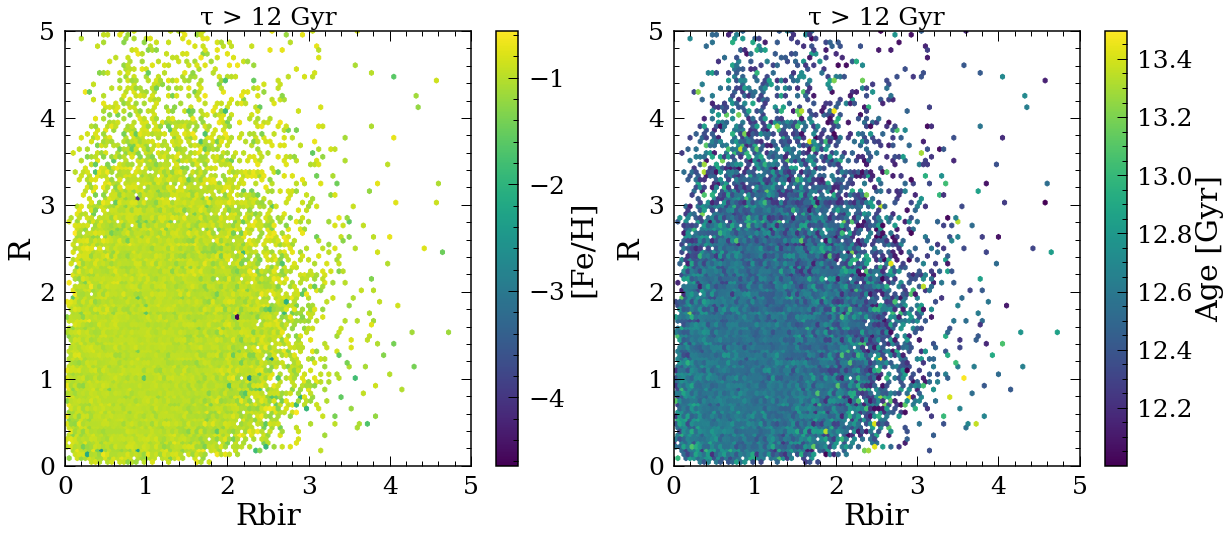

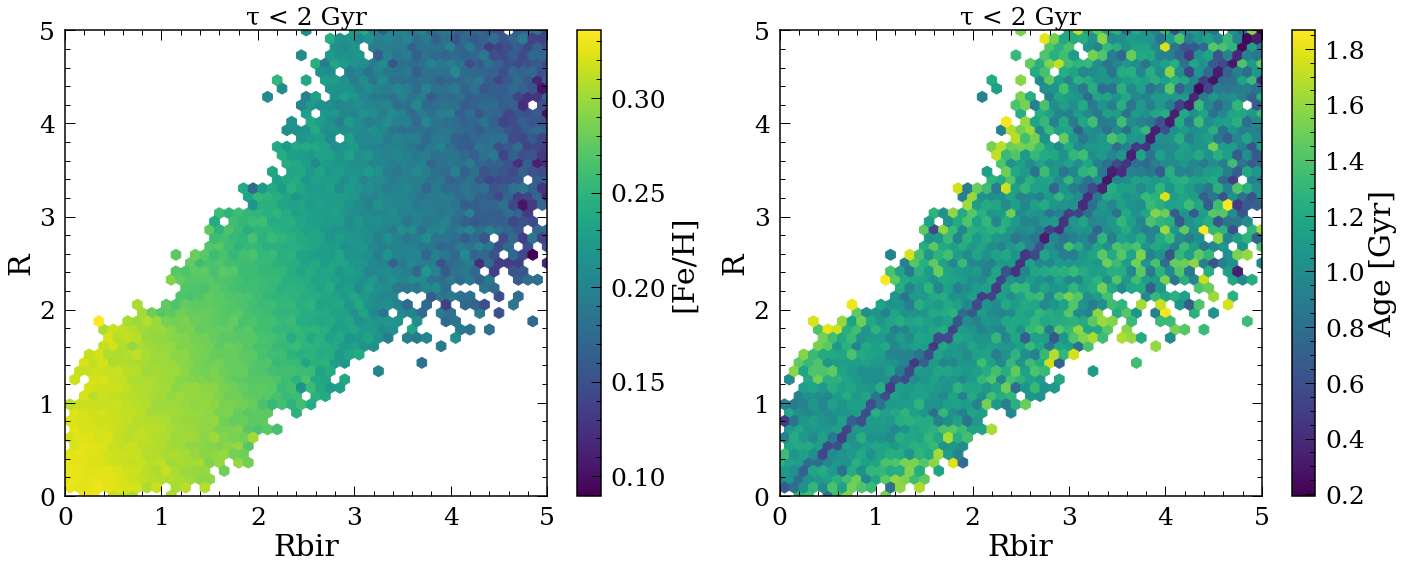

In [382]:
m_old = data['age']>12
plt.figure(figsize=(20,8))
plt.subplot(1,2,2)
plt.title('τ > 12 Gyr',fontsize=25)
plt.hexbin(data['Rbir'][m_old],data['R'][m_old], data['age'][m_old], extent = (0,5,0,5), gridsize=100, mincnt=1)
plt.xlabel('Rbir')
plt.ylabel('R')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.ylim([0,5])
plt.xlim([0,5])

plt.subplot(1,2,1)
plt.title('τ > 12 Gyr',fontsize=25)
plt.hexbin(data['Rbir'][m_old],data['R'][m_old], C = data['feh'][m_old], extent = (0,5,0,5), gridsize=100, mincnt=1)
plt.xlabel('Rbir')
plt.ylabel('R')
cb = plt.colorbar()
cb.set_label('[Fe/H]')
plt.ylim([0,5])
plt.xlim([0,5])


m_young = data['age']<2

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(data['Rbir'][m_young],data['R'][m_young], C = data['feh'][m_young], extent = (0,5,0,5), gridsize=50, mincnt=1)
plt.xlabel('Rbir')
plt.ylabel('R')
plt.ylim([0,5])
plt.xlim([0,5])
cb = plt.colorbar()
cb.set_label('[Fe/H]')
plt.title('τ < 2 Gyr',fontsize=25)

plt.subplot(1,2,2)
plt.hexbin(data['Rbir'][m_young],data['R'][m_young], C = data['age'][m_young], extent = (0,5,0,5), gridsize=50, mincnt=1)
plt.xlabel('Rbir')
plt.ylabel('R')
plt.ylim([0,5])
plt.xlim([0,5])
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('τ < 2 Gyr',fontsize=25)
plt.tight_layout()


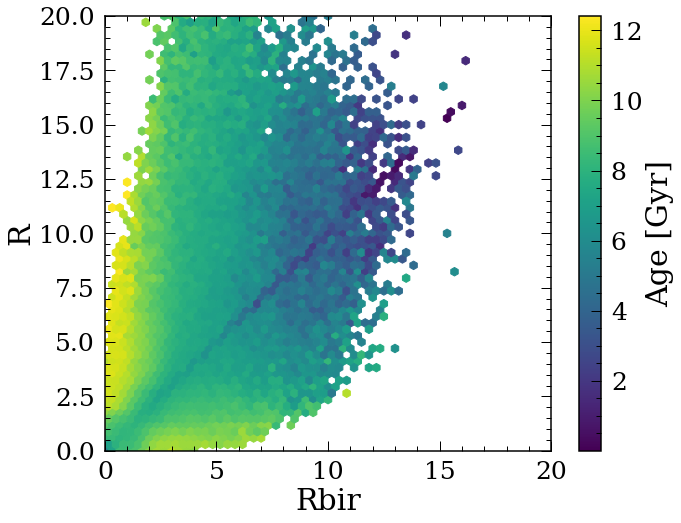

In [348]:
plt.figure(figsize=(10,8))
plt.hexbin(data['Rbir'],data['R'],C=data['age'], extent = (0,20,0,20),gridsize=60, mincnt = 5)
plt.xlabel('Rbir')
plt.ylabel('R')
plt.ylim([0,20])
plt.xlim([0,20])
cb = plt.colorbar()
cb.set_label('Age [Gyr]')